<a href="https://colab.research.google.com/github/HiwaTase/Machine-Learning/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
url = 'https://raw.githubusercontent.com/HiwaTase/Machine-Learning/main/healthINS_balanced.csv'
df = pd.read_csv(url)

# Check for missing
print("Missing values in each column:")
print(df.isnull().sum())

# Drop columns with missing values
df = df.drop(["marst","WKSWORK2", "classwkr", "empstat", "vetstat","school","cit2","metro","region"], axis=1)

# Top-code the 'inctot' column
df['inctot'] = df['inctot'].apply(lambda x: min(max(x, 0), 500000))

# Verify the remaining missing values
print("Missing values after cleaning:")
print(df.isnull().sum())

# Split the data into features and target variable
X = df.drop('nohealthins', axis=1)
y = df['nohealthins']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify the split is balanced
print("Training set target class distribution:")
print(y_train.value_counts())
print("\nTesting set target class distribution:")
print(y_test.value_counts())

Missing values in each column:
nohealthins        0
marst              0
race2              0
WKSWORK2       24857
classwkr       16731
empstat          944
inctot             0
uhrswork           0
age                0
school             0
cit2               0
educ_att           0
female             0
metro              0
region             0
vetstat         1978
dtype: int64
Missing values after cleaning:
nohealthins    0
race2          0
inctot         0
uhrswork       0
age            0
educ_att       0
female         0
dtype: int64
Training set target class distribution:
nohealthins
1    29704
0    26184
Name: count, dtype: int64

Testing set target class distribution:
nohealthins
1    7427
0    6546
Name: count, dtype: int64


In [4]:
# Assume df is loaded and cleaned as per your previous project description
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Define feature categories
categorical_features = ['race2', 'educ_att']
numerical_features = ['inctot', 'age', 'uhrswork']

# Column transformer setup
column_transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Split the data into training and testing sets
X = df.drop('nohealthins', axis=1)
y = df['nohealthins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply transformations
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)


**Step 2**

Number of components needed to capture 95% of the variance: 9


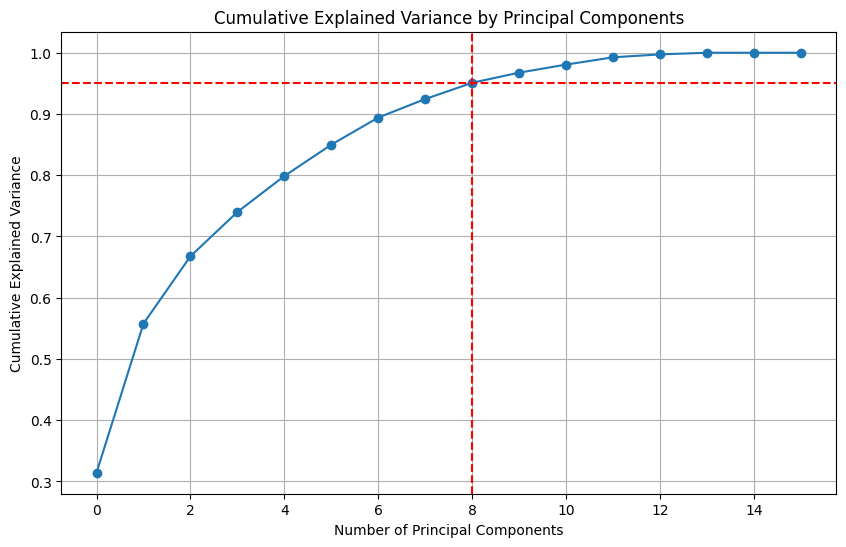

Explained Variance Ratio: 0.9509492530232708
Accuracy: 0.7622557790023617


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define parameter grids for grid search
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None]
}

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid_search.fit(X_train_transformed, y_train)

# Get the best Random Forest model
best_rf = rf_grid_search.best_estimator_

# Fit PCA to the training data
pca = PCA().fit(X_train_transformed)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components needed to capture 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components needed to capture 95% of the variance: {num_components}")

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=num_components-1, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Initialize PCA with the number of components that capture 95% variance
pca = PCA(n_components=num_components)

# Create a pipeline with PCA and the best classifier
pipeline = Pipeline(steps=[('pca', pca), ('classifier', best_rf)])

# Fit the model
pipeline.fit(X_train_transformed, y_train)

# Evaluate the model
print("Explained Variance Ratio:", pca.explained_variance_ratio_.sum())

# Predict and calculate accuracy
y_pred = pipeline.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, y_pred))


Number of components needed to capture 95% of the variance: 9


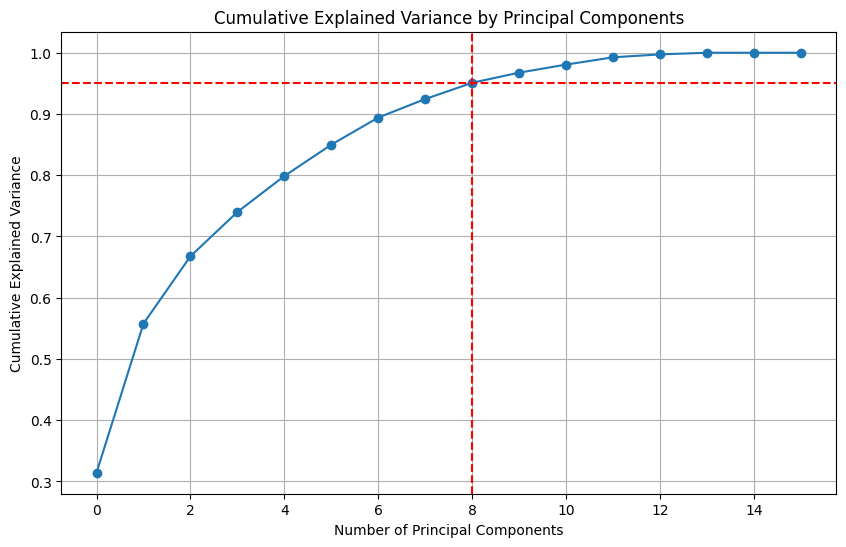

In [6]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA to the training data
pca = PCA().fit(X_train_transformed)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components needed to capture 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components needed to capture 95% of the variance: {num_components}")

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=num_components-1, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


**Step 3**

In [8]:
# Fit PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_pca = pca.fit_transform(X_train_transformed)


K-Means Clustering
Without PCA

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt

In [13]:
# K-Means without PCA
kmeans = KMeans(n_clusters=3, random_state=42)  # Example with 3 clusters
clusters_kmeans = kmeans.fit_predict(X_train_transformed)

# Evaluation
ari_kmeans = adjusted_rand_score(y, clusters_kmeans)
silhouette_kmeans = silhouette_score(X_train_transformed, clusters_kmeans)

print(f"K-Means clustering without PCA: ARI = {ari_kmeans:.4f}, Silhouette = {silhouette_kmeans:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [69861, 55888]

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt

# Load the data
url = 'https://raw.githubusercontent.com/HiwaTase/Machine-Learning/main/healthINS_balanced.csv'
df = pd.read_csv(url)

# Drop columns with missing values
df = df.drop(["marst","WKSWORK2", "classwkr", "empstat", "vetstat","school","cit2","metro","region"], axis=1)

# Top-code the 'inctot' column
df['inctot'] = df['inctot'].apply(lambda x: min(max(x, 0), 500000))

# Split the data into features and target variable
X = df.drop('nohealthins', axis=1)
y = df['nohealthins']

# Define feature categories
categorical_features = ['race2', 'educ_att']
numerical_features = ['inctot', 'age', 'uhrswork']

# Column transformer setup
column_transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Apply transformations
X_transformed = column_transformer.fit_transform(X)


In [15]:
# Fit PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_pca = pca.fit_transform(X_transformed)


In [16]:
# K-Means without PCA
kmeans = KMeans(n_clusters=3, random_state=42)  # Example with 3 clusters
clusters_kmeans = kmeans.fit_predict(X_transformed)

# Evaluation
ari_kmeans = adjusted_rand_score(y, clusters_kmeans)
silhouette_kmeans = silhouette_score(X_transformed, clusters_kmeans)

print(f"K-Means clustering without PCA: ARI = {ari_kmeans:.4f}, Silhouette = {silhouette_kmeans:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering without PCA: ARI = 0.0362, Silhouette = 0.2065


In [17]:
# K-Means with PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_pca = kmeans_pca.fit_predict(X_pca)

# Evaluation
ari_kmeans_pca = adjusted_rand_score(y, clusters_kmeans_pca)
silhouette_kmeans_pca = silhouette_score(X_pca, clusters_kmeans_pca)

print(f"K-Means clustering with PCA: ARI = {ari_kmeans_pca:.4f}, Silhouette = {silhouette_kmeans_pca:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering with PCA: ARI = 0.0360, Silhouette = 0.2216


In [ ]:
# Agglomerative Clustering without PCA
agglo = AgglomerativeClustering(n_clusters=3)
clusters_agglo = agglo.fit_predict(X_transformed)

# Evaluation
ari_agglo = adjusted_rand_score(y, clusters_agglo)
silhouette_agglo = silhouette_score(X_transformed, clusters_agglo)

print(f"Agglomerative clustering without PCA: ARI = {ari_agglo:.4f}, Silhouette = {silhouette_agglo:.4f}")


In [ ]:
# Agglomerative Clustering with PCA
agglo_pca = AgglomerativeClustering(n_clusters=3)
clusters_agglo_pca = agglo_pca.fit_predict(X_pca)

# Evaluation
ari_agglo_pca = adjusted_rand_score(y, clusters_agglo_pca)
silhouette_agglo_pca = silhouette_score(X_pca, clusters_agglo_pca)

print(f"Agglomerative clustering with PCA: ARI = {ari_agglo_pca:.4f}, Silhouette = {silhouette_agglo_pca:.4f}")


In [ ]:
# DBSCAN without PCA
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_transformed)

# Evaluation
# For DBSCAN, some points may be labeled as noise (-1), so we filter these out for evaluation
mask = clusters_dbscan != -1
ari_dbscan = adjusted_rand_score(y[mask], clusters_dbscan[mask])
silhouette_dbscan = silhouette_score(X_transformed[mask], clusters_dbscan[mask])

print(f"DBSCAN clustering without PCA: ARI = {ari_dbscan:.4f}, Silhouette = {silhouette_dbscan:.4f}")


In [ ]:
# DBSCAN with PCA
dbscan_pca = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan_pca = dbscan_pca.fit_predict(X_pca)

# Evaluation
mask_pca = clusters_dbscan_pca != -1
ari_dbscan_pca = adjusted_rand_score(y[mask_pca], clusters_dbscan_pca[mask_pca])
silhouette_dbscan_pca = silhouette_score(X_pca[mask_pca], clusters_dbscan_pca[mask_pca])

print(f"DBSCAN clustering with PCA: ARI = {ari_dbscan_pca:.4f}, Silhouette = {silhouette_dbscan_pca:.4f}")


In [ ]:
def plot_clusters(X, clusters, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
    plt.title(title)
    plt.show()

# Example visualization for K-Means with PCA
plot_clusters(X_pca, clusters_kmeans_pca, "K-Means Clustering with PCA")

# Example visualization for Agglomerative Clustering with PCA
plot_clusters(X_pca, clusters_agglo_pca, "Agglomerative Clustering with PCA")

# Example visualization for DBSCAN with PCA
plot_clusters(X_pca, clusters_dbscan_pca, "DBSCAN Clustering with PCA")
